# Imports

In [1]:
import os
import tarfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Download and Prepare Dataset

In [2]:
DOWNLOAD_URL = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(DOWNLOAD_URL, ".")

with tarfile.open("./cifar10.tgz", "r:gz") as tar:
  tar.extractall(path="./data")

DATA_DIR = "data/cifar10"
print(os.listdir(DATA_DIR))
classes = os.listdir(DATA_DIR + "/train")
print(classes)

  0%|          | 0/135107811 [00:00<?, ?it/s]

['train', 'test']
['dog', 'deer', 'automobile', 'truck', 'ship', 'cat', 'bird', 'horse', 'airplane', 'frog']


### Visualize Channel Distribution and Get Stats

In [3]:
dataset = ImageFolder(DATA_DIR + "/train", transform=tt.ToTensor())

images = [image for (image, _) in dataset]
images = torch.stack(images)
images.shape

torch.Size([50000, 3, 32, 32])

In [4]:
images = images.permute(1, 0, 2, 3)
images.shape

torch.Size([3, 50000, 32, 32])

In [5]:
images = images.reshape(3, -1)
images.shape

torch.Size([3, 51200000])

In [6]:
channel1, channel2, channel3 = [channel.numpy() for channel in images]
len(channel1), len(channel2), len(channel3)

(51200000, 51200000, 51200000)

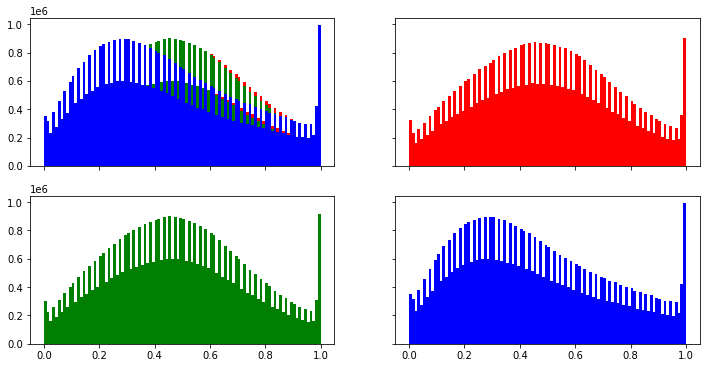

In [7]:
figure, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
# figure.set_size_inches((12, 6))

hist1 = ax[0, 0].hist(channel1, bins=100, color="red")
hist2 = ax[0, 0].hist(channel2, bins=100, color="green")
hist3 = ax[0, 0].hist(channel3, bins=100, color="blue")

hist1 = ax[0, 1].hist(channel1, bins=100, color="red")
hist2 = ax[1, 0].hist(channel2, bins=100, color="green")
hist3 = ax[1, 1].hist(channel3, bins=100, color="blue")

In [8]:
stats_mean = [image.mean() for image in images]
stats_std = [image.std() for image in images]

calc_stats = (tuple(stats_mean), tuple(stats_std))
calc_stats

((tensor(0.4914), tensor(0.4822), tensor(0.4465)),
 (tensor(0.2470), tensor(0.2435), tensor(0.2616)))

### Data Transforms (Augmentation and Normalization)

In [30]:
given_stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = calc_stats

train_tfms = tt.Compose([tt.RandomCrop((32,32), padding=4, padding_mode="reflect"),
                        tt.RandomHorizontalFlip(p=0.5),
                        # tt.RandomRotate
                        # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        tt.ToTensor(),
                        tt.Normalize(*stats, inplace=True)])

val_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats, inplace=True)])

### ImageFolder and DataLoader

In [10]:
train_ds = ImageFolder(DATA_DIR + "/train", train_tfms)
val_ds = ImageFolder(DATA_DIR + "/test", val_tfms)

In [11]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=2, pin_memory=True)

In [12]:
def denormalize(image, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return image * stds + means

def show_batch(dl):
  for images, _ in dl:
    figure, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    plt.imshow(make_grid(denorm_images, nrow=16).permute(1, 2, 0).clip(0, 1))
    break

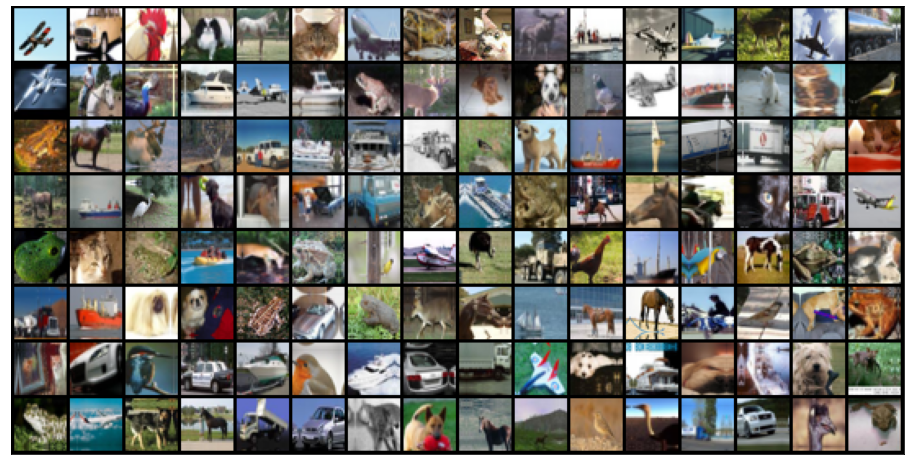

In [31]:
show_batch(train_dl)

# Using a GPU

In [ ]:
def get_device():
  """Pick GPU if GPU is available, else pick CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

In [ ]:
device = get_device()
device

In [ ]:
def to_device(data, device):
  """Move Tensors to specified device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [86]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    """Returns the number of batches in the dataloader"""
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

# Model

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [57]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f} val_Loss: {:.4f}, val_Acc: {:.4f}".format(
        epoch,
        result["lrs"][-1],
        result["train_loss"],
        result["val_loss"],
        result["val_acc"]))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))  # default stride == kernel_size
  return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
    
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    return self.classifier(out)

In [40]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training

In [41]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [42]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]

In [43]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    # Training Step
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Clip the Gradient
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record and Update the Learning Rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation Step
    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["lrs"] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [44]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09879351407289505, 'val_loss': 2.3049864768981934}]

In [45]:
epochs = 8
max_lr = 0.01
weight_decay = 1e-5
grad_clip = 0.1
opt_func = torch.optim.Adam

In [46]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
               weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

Epoch [0], last_lr: 0.003948606820661788, train_loss: 1.440634846687317 val_Loss: 1.4524, val_Acc: 0.5443
Epoch [1], last_lr: 0.009355580733907874, train_loss: 1.0593222379684448 val_Loss: 0.7364, val_Acc: 0.7431
Epoch [2], last_lr: 0.009719417773875232, train_loss: 0.7275097370147705 val_Loss: 0.7006, val_Acc: 0.7602
Epoch [3], last_lr: 0.00811745653949763, train_loss: 0.5690309405326843 val_Loss: 0.5531, val_Acc: 0.8134
Epoch [4], last_lr: 0.005559840141227017, train_loss: 0.45956552028656006 val_Loss: 0.4745, val_Acc: 0.8404
Epoch [5], last_lr: 0.0028306099820869924, train_loss: 0.3677932322025299 val_Loss: 0.3513, val_Acc: 0.8803
Epoch [6], last_lr: 0.0007664159383425639, train_loss: 0.25888583064079285 val_Loss: 0.2959, val_Acc: 0.9010
Epoch [7], last_lr: 4e-08, train_loss: 0.18998245894908905 val_Loss: 0.2713, val_Acc: 0.9107
CPU times: user 57.5 s, sys: 5.38 s, total: 1min 2s
Wall time: 4min 45s


In [47]:
train_time = "4:45"

In [48]:
def plot_accuracies(history):
  accuracies = [result["val_acc"] for result in history]
  plt.plot(accuracies, "-x")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracies")
  plt.title("Accuracy vs Epoch")

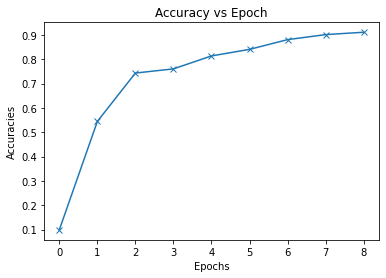

In [49]:
plot_accuracies(history)

In [50]:
def plot_losses(history):
  train_losses = [result.get("train_loss") for result in history]
  val_losses = [result["val_loss"] for result in history]
  plt.plot(train_losses, "-rx")
  plt.plot(val_losses, "-bx")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss vs Epochs")
  plt.legend(["Training", "Vaalidation"])

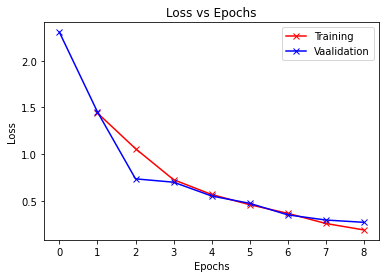

In [51]:
plot_losses(history)

In [71]:
def plot_lrs(history):
  lrs = np.concatenate([result.get("lrs", []) for result in history])
  plt.plot(lrs, "-")
  plt.xlabel("Batch No.")
  plt.ylabel("Learning Rate")
  plt.title("Learning Rate vs Batch No.")

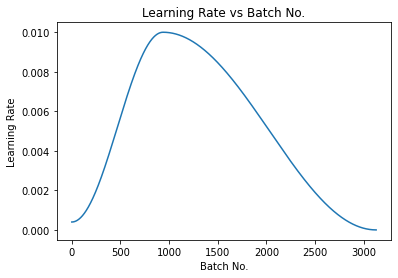

In [72]:
plot_lrs(history)

# Test Inidividual Image and Evaluate on Test Set

In [73]:
test_dataset = ImageFolder(DATA_DIR+"/test", transform=val_tfms)

In [74]:
def predict_image(image, model):
  image = to_device(image.unsqueeze(0), device)
  out = model(image)
  _, preds = torch.max(out, dim=1)
  return preds[0].item()

Label: automobile Predicted: automobile


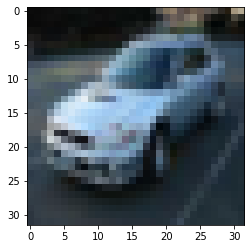

In [78]:
image, label = test_dataset[17]
plt.imshow(denormalize(image.unsqueeze(0), *stats).squeeze(0).permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

Label: airplane Predicted: airplane


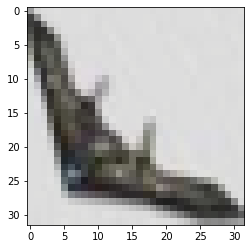

In [80]:
image, label = test_dataset[17]
plt.imshow(denormalize(image.unsqueeze(0), *stats).squeeze(0).permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

Label: ship Predicted: ship


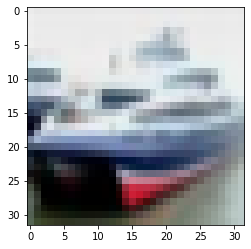

In [82]:
image, label = test_dataset[8000]
plt.imshow(denormalize(image.unsqueeze(0), *stats).squeeze(0).permute(1, 2, 0))
print("Label: {} Predicted: {}".format(dataset.classes[label], dataset.classes[predict_image(image, model)]))

In [87]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, BATCH_SIZE*2), device)
test_result = evaluate(model, test_loader)
test_result

{'val_acc': 0.911816418170929, 'val_loss': 0.26842519640922546}

# Save Model

In [89]:
torch.save(model.state_dict(), "cifar10_resnet9.pth")

In [92]:
model2 = to_device(ResNet9(3, 10), device)
model2.load_state_dict(torch.load("cifar10_resnet9.pth"))

<All keys matched successfully>

In [93]:
evaluate(model2, test_loader)

{'val_acc': 0.911816418170929, 'val_loss': 0.26842519640922546}

In [ ]:
# Save the Experiment